# Import Modules

In [1]:
import netCDF4 as nc4
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prepro

# Loading and preprocessing the data

In [2]:
f = nc4.Dataset('SingleLevel/ugrd_pres_latlon_all_20000805_20180805_rasslD5yJo.nc','r')
#visualizing the data
#f.variables

In [4]:
#Extracting wind in X direction
matrix_u = f.variables['U-component_of_wind'][:]
#showing matrix shape
matrix_u.shape

In [6]:
#Cleanning bad values
mask = np.ma.getmask(matrix_u)
vec = []
for i in range(len(mask)):
    if np.sum(mask[i,:,:,:,:,:]) > 1:
        #print bad values based on the mask
        print(i)
        vec += [i]
matrix_u = np.delete(matrix_u,vec,0)

6324
6408


In [7]:
#New matrix shape
matrix_u.shape

(6573, 11, 1, 1, 46, 76)

In [8]:
#Reshape to work shape
w_x = matrix_u.reshape([len(matrix_u),11,46,76,1])
w_x.shape

(6573, 11, 46, 76, 1)

In [9]:
#Normalizing
w_x = (w_x[:] + 150)/(300)

In [10]:
#Splitting data set
test_samples = 600

X_train = w_x[:-test_samples,0,:,:,:]
X_test = w_x[-test_samples:,0,:,:,:]

y_train = w_x[:-test_samples,1:,:,:,:]
y_test = w_x[-test_samples:,1:,:,:,:]

In [12]:
#Reshaping to work shape
y_train = np.moveaxis(y_train,1,-1)
y_train = y_train.reshape([len(y_train),46,76,10])

y_test = np.moveaxis(y_test,1,-1)
y_test = y_test.reshape([len(y_test),46,76,10])

In [13]:
#Verifying data shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5973, 46, 76, 1)
(5973, 46, 76, 10)
(600, 46, 76, 1)
(600, 46, 76, 10)


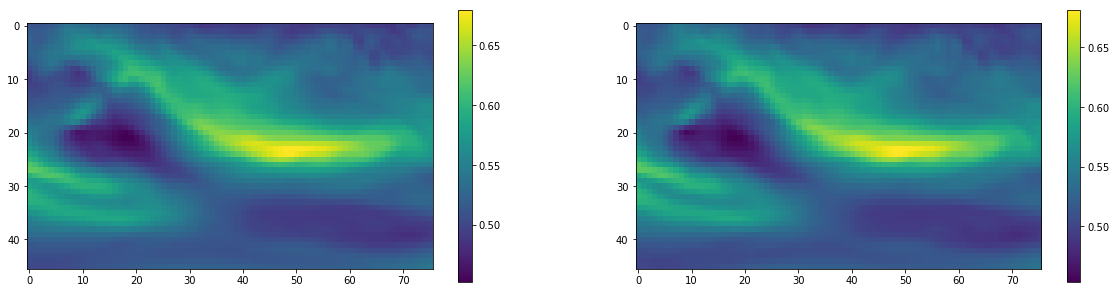

In [14]:
#Plot example figures from train data set
plt.figure(figsize=(20, 5))   
plt.subplot(1, 2, 1)
img = plt.imshow(X_train[0,:,:,0])
plt.colorbar(img)
plt.subplot(1, 2, 2)
img = plt.imshow(y_train[0,:,:,0])
plt.colorbar(img)

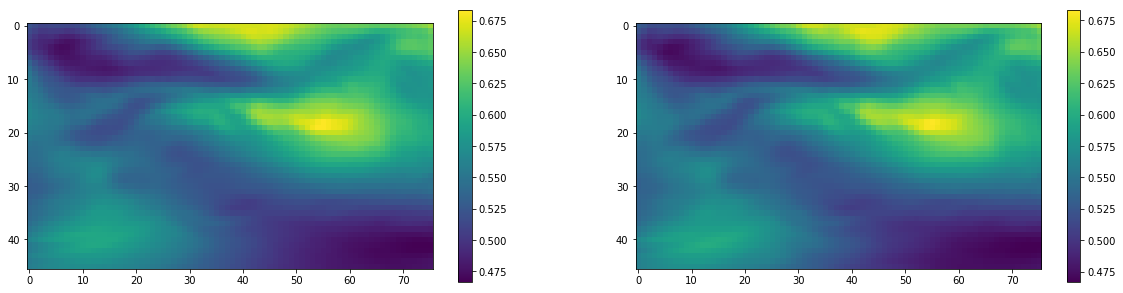

In [15]:
#Plot example figures from test data set
plt.figure(figsize=(20, 5))   
plt.subplot(1, 2, 1)
img = plt.imshow(X_test[0,:,:,0])
plt.colorbar(img)
plt.subplot(1, 2, 2)
img = plt.imshow(y_test[0,:,:,0])
plt.colorbar(img)

# Autoencoder implementation

In [16]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Add, Lambda, Activation
from keras.models import Model
from keras import backend as K
from keras.models import load_model

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
def noising(args):
    '''
    Function to noise the encoder output with a Gaussian noise.
    '''
    input_img = args
    #dim = K.int_shape(input_img)[1]*K.int_shape(input_img)[2]
    epsilon = K.random_normal(shape=(11, 19, 32),
                              mean=0., stddev=.01)
    print(epsilon)
    return input_img + epsilon*input_img

In [18]:
#defining the networking structure using keras

input_img = Input(shape=(44, 76, 1)) # adapt this if using `channels_first` image data format

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoded = Lambda(noising)(encoded)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss='mse')

print(autoencoder.summary())

Tensor("lambda_1/random_normal:0", shape=(11, 19, 32), dtype=float32)
Tensor("lambda_1/random_normal_1:0", shape=(11, 19, 32), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44, 76, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 76, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 38, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 38, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 19, 32)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 11, 19, 32)        0         


In [ ]:
#Training over the data
count = 0
for j in range(100):
    count +=1
    name_save = 'weights/'+ 'VAE_test1-' + str(count) + '.h5'
    for i in range(10):
        print('\n')
        print(i)

        autoencoder.fit(X_train[:,:44,:,:], y_train[:,:44,:,i:i+1],
                    epochs=10,
                    batch_size=32,
                    shuffle=True,
                    validation_split=0.1, verbose = 2)#validation_data=(X_test[:,:44,:,:], y_test[:,:44,:,0:1]))

    autoencoder.save(name_save)
print('IT S OVERRRRRRRRRRRR')



0
Train on 5375 samples, validate on 598 samples
Epoch 1/10
 - 3s - loss: 1.0069e-05 - val_loss: 1.0464e-05
Epoch 2/10
 - 3s - loss: 1.0283e-05 - val_loss: 1.1331e-05
Epoch 3/10


In [149]:
#name_save = ''
print(name_save) #last saved file
autoencoder.save(name_save) #saving autoencoder weights
#autoencoder = load_model(name_save) #loading weights

'weights/VAE_test1-6.h5'

# Plotting results

In [32]:
i =2
ab = autoencoder.predict(X_test[i:i+1,:44,:,:])

In [34]:
print('dist(1forc x Pred)')
print(np.sum(np.sqrt((X_test[i,:44,:,0]-ab[0,:,:,0])**2)))

print('Nforc x Pred')
for j in range(10):
    print(np.sum(np.sqrt((y_test[i,:44,:,j]-ab[0,:,:,0])**2)))
    
print('1forc x Nforc')
for j in range(10):
    print(np.sum(np.sqrt((y_test[i,:44,:,j]-X_test[i,:44,:,0])**2)))

dist(1forc x Pred)
3.1917696
Nforc x Pred
6.7400775
7.5889125
6.0823603
8.653995
8.165239
8.862896
8.529654
7.830302
7.1608076
5.5969844
1forc x Nforc
6.0941734
6.92895
5.274062
7.5701313
7.2278433
7.618008
8.391706
6.9029646
6.3764935
4.9724464


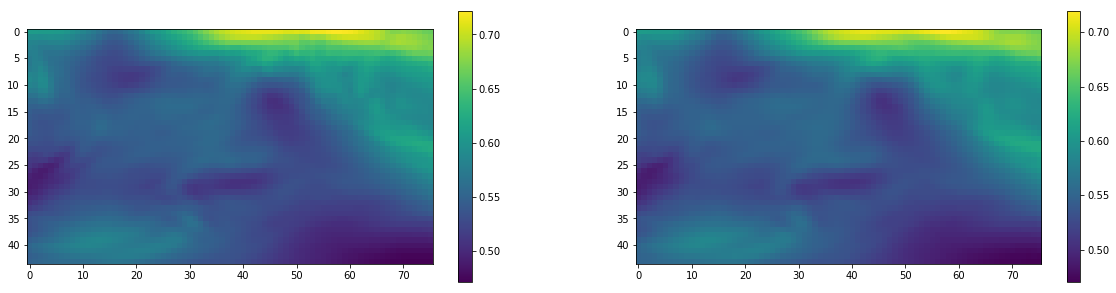

In [36]:
print('Input and Prediction')
plt.figure(figsize=(20, 5))   
plt.subplot(1, 2, 1)
img = plt.imshow(X_test[i,:44,:,0])
plt.colorbar(img)
plt.subplot(1, 2, 2)
img = plt.imshow(ab[0,:,:,0])
plt.colorbar(img)

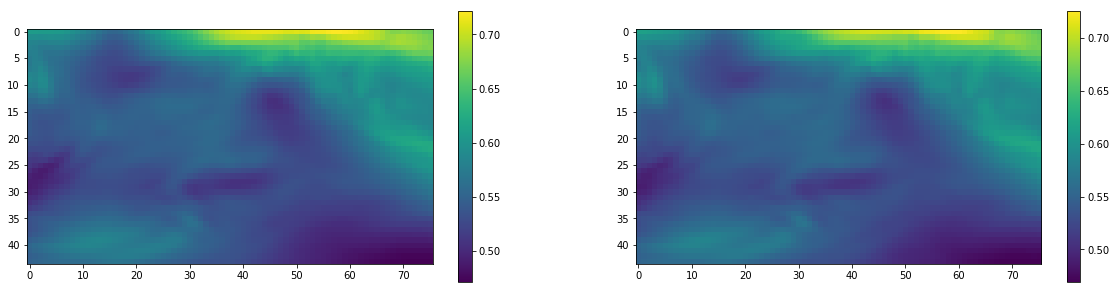

In [37]:
print('Input and an Ensemble member')
plt.figure(figsize=(20, 5))   
plt.subplot(1, 2, 1)
img = plt.imshow(X_test[i,:44,:,0])
plt.colorbar(img)
plt.subplot(1, 2, 2)
img = plt.imshow(y_test[i,:44,:,8])
plt.colorbar(img)

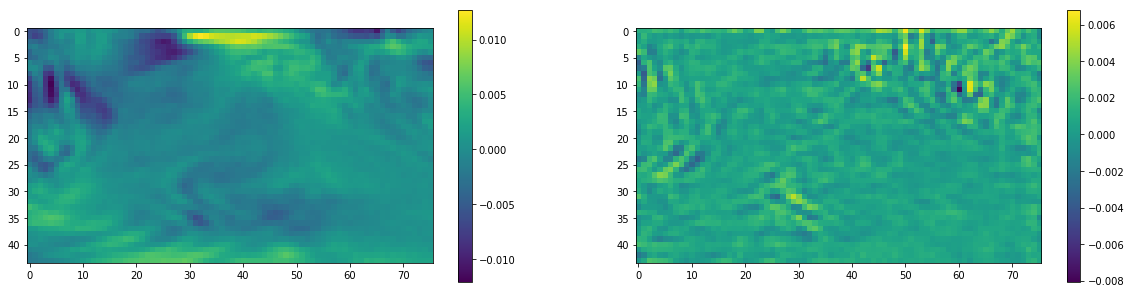

In [38]:
print('Difference between input and: ensemble member (left); prediction (right).')
plt.figure(figsize=(20, 5))   
plt.subplot(1, 2, 1)
img = plt.imshow(((X_test[i,:44,:,0]-y_test[i,:44,:,8])))
plt.colorbar(img)
plt.subplot(1, 2, 2)
img = plt.imshow(((X_test[i,:44,:,0]-ab[0,:,:,0])))
plt.colorbar(img)

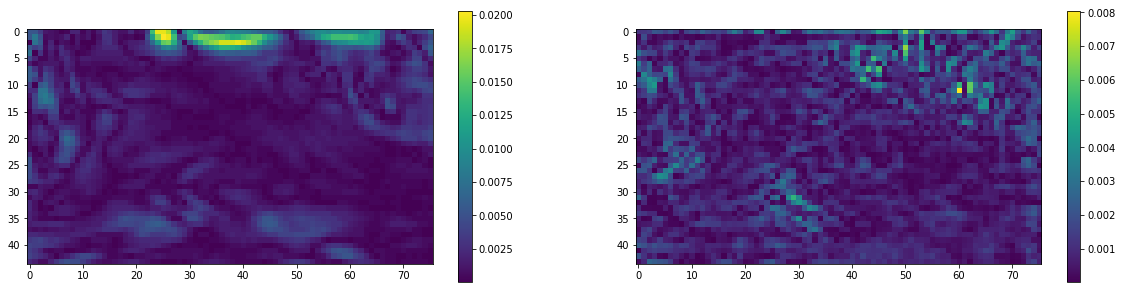

In [39]:
print('Absolute difference between input and: ensemble member (left); prediction (right).')
plt.figure(figsize=(20, 5))   
plt.subplot(1, 2, 1)
img = plt.imshow(np.sqrt((X_test[i,:44,:,0]-y_test[i,:44,:,0])**2))
plt.colorbar(img)
plt.subplot(1, 2, 2)
img = plt.imshow(np.sqrt((X_test[i,:44,:,0]-ab[0,:,:,0])**2))
plt.colorbar(img)

In [47]:
print('Y_train x X_train')
for j in range(10):
    print(np.mean(np.sqrt( (y_train[:,:44,:,j]-X_train[:,:44,:,0])**2 )))
print('Y_test x X_test')
for j in range(10):
    print(np.mean(np.sqrt( (y_test[:,:44,:,j]-X_test[:,:44,:,0])**2 )))
print('Y_test x Y_pred')
y_pred = autoencoder.predict(X_test[:,:44,:,:])
for j in range(10):
    print(np.mean (np.sqrt ((y_test[:,:44,:,j] - y_pred[:,:,:,0])**2) ) )
print('X_test x Y_pred')
print(np.mean (np.sqrt ((X_test[:,:44,:,0] - y_pred[:,:,:,0])**2) ) )

#print('some data')
#for j in range(10):
#    print(np.mean(np.sqrt( (y_train[:1000,:44,:,j]-X_train[:1000,:44,:,0])**2 )))

Y_train x X_train
0.0017360398586026473
0.0019028853321681018
0.0018905157532811128
0.001906538571485861
0.0019127748935075263
0.001915341939507789
0.0019148049055052962
0.0019151109718614147
0.0019087911416390704
0.0017455674206927586
Y_test x X_test
0.0018366837691652337
0.001959256988963442
0.0019879919414124802
0.001993502627529406
0.002017010288755669
0.002007504209186852
0.002013555523691375
0.002015411522970245
0.0020246373713491824
0.002000875031929077
Y_test x Y_pred
0.0023015729548258074
0.00241865142870938
0.002415523011908767
0.002406348269521905
0.0024303111391204397
0.0024313982365804427
0.0024420535925662877
0.002453938412704346
0.0024488107781661184
0.0024315238113038276
X_test x Y_pred
0.001341799746670031
